In [1]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import gaussian_kde

In [2]:
os.chdir("OriginalFromAllenDB")

In [3]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
from modules import spike_train_generation

In [4]:
from neuron import h
h.load_file("stdrun.hoc")  # Required to use h.run()

1.0

In [5]:
h.nrn_load_dll("modfiles/x86_64/.libs/libnrnmech.so")

0.0

In [ ]:

class AllenCell:
    def __init__(self, gid, soma_diam_multiplier=1.0):
        
        self._gid = gid
        self.synapses = []  # Keep track of all synapses
        self.netcons = []   # Keep track of NetCons
        self.stims = []     # Keep VecStims so they don't get garbage-collected
        self.vecs = []
        self.syn_locs = [] 
        
        description = Config().load('manifest.json')

        self.utils = Utils(description)
        self.h = self.utils.h
        self.Vinit = self.utils.description.data['conditions'][0]['v_init']
        # Cast all genome values to float
        for d in self.utils.description.data['genome']:
            if 'value' in d:
                d['value'] = float(d['value'])

        # Load morphology and parameters
        morphology_path = description.manifest.get_path('MORPHOLOGY')
        self.utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
        self.utils.load_cell_parameters()
        self.setup_morphology(soma_diam_multiplier)
        self._build_section_list()
    
    def setup_morphology(self,soma_diam_multiplier):

        self.soma = self.h.soma
        self.h.soma[0].diam *= soma_diam_multiplier
        self.dend = list(self.h.dend) if hasattr(self.h, 'dend') else []
        self.apic = list(self.h.apic) if hasattr(self.h, 'apic') else []
        self.axon = list(self.h.axon) if hasattr(self.h, 'axon') else []
        from neuron import h

        # Step 1: Set distance origin once (assuming soma(0.5) is your origin)
        h.distance(0, self.soma[0](0.5))

        # Step 2: Classify dendrites into proximal/distal
        self.proximal_dend_segs = []
        self.distal_dend_segs = []

        for sec in self.dend:
            for seg in sec:
                if 20 < h.distance(seg) < 100:
                    self.proximal_dend_segs.append(seg)  
                elif  h.distance(seg) >= 100:
                    self.distal_dend_segs.append(seg)


    def _build_section_list(self):
        self.all = h.SectionList()
        for sec in h.allsec():
            self.all.append(sec)
    
    def compute_corrected_weights(self,distances, target_dist_func, bandwidth=10):
        """
        Compute sampling weights that correct for anatomical bias and follow a target distribution.

        Parameters:
        - seg_list: list of (sec, loc, dist)
        - target_dist_func: function mapping distance → desired probability (e.g. scipy poisson.pmf)
        - bandwidth: KDE smoothing bandwidth (in µm)

        Returns:
        - normalized weights (np.array)
        """

        # Step 1: Estimate anatomical density using KDE
        kde = gaussian_kde(distances, bw_method=bandwidth / np.std(distances))
        anatomical_pdf = kde(distances)

        # Step 2: Evaluate target distribution at each distance
        target_pdf = target_dist_func(distances)

        # Step 3: Divide target by anatomical density to correct for bias
        raw_weights = target_pdf / (anatomical_pdf + 1e-12)

        # Step 4: Normalize
        weights = raw_weights / raw_weights.sum()

        return weights
    
    
            
    def add_random_synapses_from_df(self,df, syn_name,syn_params,dist_func,seg_list=None):
        
        
        for _, row in df.iterrows():
            timestamps = row['timestamps']
            
            if not timestamps:
                continue

            # sec_seg = random.choice(seg_list)

            
            h.distance(0, self.soma[0](0.5))
            distances = [h.distance(seg) for seg in seg_list]
            # distances = []
            # for sec in seg_list:
            #     distances += [h.distance(seg) for seg in sec]
            # distances = np.array(distances) 
            
            # dist_func =  lambda d: 1 for uniform
            weights = self.compute_corrected_weights(distances,dist_func)
            sec_seg = random.choices(seg_list, weights=weights, k=1)[0]
            
            
            self.syn_locs.append(sec_seg)
            # Create synapse
            syn = getattr(h, syn_name)(sec_seg)
            for param, val in syn_params.items():
                if hasattr(syn, param):
                    setattr(syn, param, val)

            # Create VecStim with spike times
            vec = h.Vector(timestamps)
            self.vecs.append(vec)
            stim = h.VecStim()
            stim.play(vec)
            self.stims.append(stim)

            nc = h.NetCon(stim, syn)
            nc.weight[0] = syn_params.get('initW')

            self.synapses.append(syn)
            self.netcons.append(nc)

            
    def __str__(self):
        return f"AllenCell(soma={self.soma}, dendrites={len(self.dend)})"

In [22]:
dist_func =  lambda d: 1

In [ ]:
# from scipy.stats import poisson
# lam = 120
# dist_func = lambda d: poisson.pmf(np.round(d).astype(int), mu=lam)

In [23]:
cell = AllenCell(0,soma_diam_multiplier=6)
cell.add_random_synapses_from_df(grouped, "AMPA_NMDA_STP", syn_params, dist_func, seg_list=cell.proximal_dend_segs+cell.distal_dend_segs)
cell.add_random_synapses_from_df(grouped_stim, "AMPA_NMDA_STP", syn_params,dist_func, seg_list=cell.proximal_dend_segs+cell.distal_dend_segs)

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [24]:
syn_params =  {
            'initW': 1.2,
            'tau_r_AMPA': 5,
            'tau_d_AMPA': 4,
            'Use': 0.34,
            'Dep': 0.,
            'Fac': 80.,
            'NMDA_ratio': 1.5
        }

In [8]:
PFR = pd.read_csv(os.path.join("..","pyrFiringRateAvg.csv"),delimiter=",")
PFR_time_shortened = np.array(PFR['Time'][PFR['Time'] >0])
PFR_firing_rate_shortened = np.array(PFR['AvgFiringRate'][PFR['Time'] >0])

In [9]:
def get_num_spikes(freq,dur):
    return int(freq * (dur / 1000))

In [10]:
stim_start, stim_end = 100,1000
freqs = [5,20,50,100]
event_times = []
for freq in freqs:
    event_times.append(np.linspace(stim_start,stim_end, get_num_spikes(freq, stim_end-stim_start)))

In [82]:
cell = AllenCell(0,soma_diam_multiplier=6)
syn_params =  {
            'initW': 1.2,
            'tau_r_AMPA': 5,
            'tau_d_AMPA': 4,
            'Use': 0.34,
            'Dep': 0.,
            'Fac': 80.,
            'NMDA_ratio': 1.5
        }
        # 'spec_syn_param': {
        #     'initW': 1.2,
        #     'tau_r_AMPA': 5,
        #     'tau_d_AMPA': 4,
        #     'Use': 0.34,
        #     'Dep': 0.,
        #     'Fac': 80.,
        #     'NMDA_ratio': 1.5
        # }

ts, vs,ics = [],[],[]
for i, time in enumerate(event_times):
    
    syn = getattr(h, "AMPA_NMDA_STP")(cell.proximal_dend_segs[0])
    for param, val in syn_params.items():
        if hasattr(syn, param):
            setattr(syn, param, val)
    vec = h.Vector(time)
    stim = h.VecStim()
    stim.play(vec)
    nc = h.NetCon(stim, syn)
    nc.weight[0] = syn_params.get('initW', 0.001)

    vc = h.VClamp(cell.soma[0](0.5))
    vc.dur[0] = 1000   # ms
    vc.amp[0] = -70   # mV
 
    
    ic = h.Vector().record(vc._ref_i)
    tvec = h.Vector().record(h._ref_t)
    vvec = h.Vector().record(cell.soma[0](0.5)._ref_v)  # somatic Vm

    # Simulation control
    h.finitialize(cell.Vinit)
    h.tstop = 1000.0  # ms
    h.run()
    
    ts.append(np.array(tvec))
    vs.append(np.array(vvec))
    ics.append(np.array(ic))

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


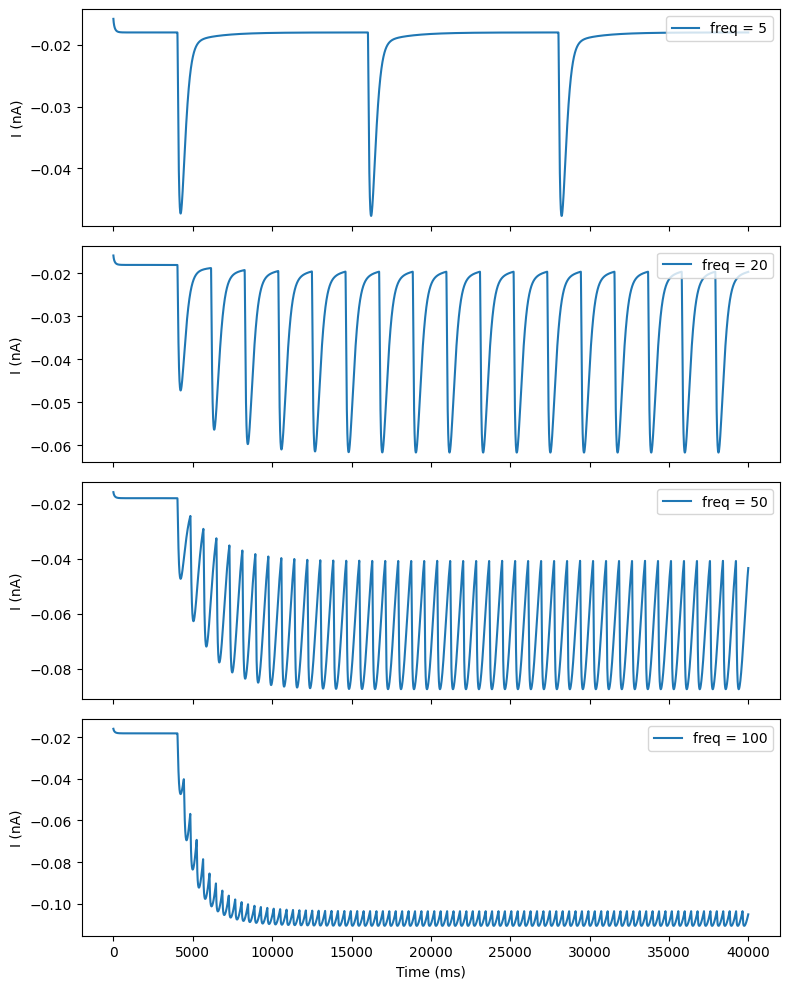

In [83]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=4, figsize=(8, 10), sharex=True)

for i in range(4):
    T, V,Ics = np.array(ts[i]), np.array(vs[i]),np.array(ics[i])
    axes[i].plot(Ics[10:], label=f"freq = {freqs[i]}")
    axes[i].set_ylabel("I (nA)")
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


In [11]:
def inhomogeneous_poisson_through_num_points(lambdas, win_length):
    t = np.zeros(len(lambdas) * win_length)
    lambdas = np.divide(lambdas,1000/win_length)
    
    for i, lambd in enumerate(lambdas):

        num_points = np.random.poisson(lambd)

        if num_points >= win_length:
            t[i * win_length : (i + 1) * win_length] = 1
            continue

        random_inds = np.random.choice(a = np.arange(win_length), size = num_points, replace = False)
        spikes = np.zeros(win_length)
        spikes[random_inds] = 1
        t[i * win_length : (i + 1) * win_length] = spikes

    return t

In [39]:
N_stim = 50
all_spike_times = []
bin_size = 5


for i in range(N_stim):

    spikes=inhomogeneous_poisson_through_num_points(PFR_firing_rate_shortened,int(bin_size))
    time = np.arange(len(spikes))
    timestamps = time[spikes==1]
    all_spike_times.append(timestamps)


df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_spike_times) for t in times])
grouped_stim = df.groupby('node_ids')['timestamps'].apply(list).reset_index()
len(grouped_stim["timestamps"][0])

2

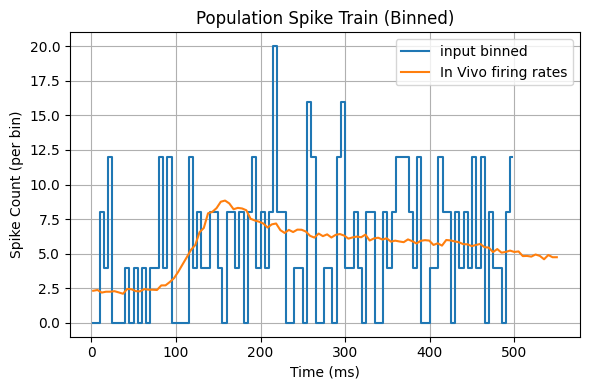

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Step 1: Combine all spike times into one flat array
all_spike_times = np.concatenate(grouped_stim['timestamps'].values)

# Step 2: Define bins
bin_width = 5  # ms
t_min = 0
t_max = 500
bins = np.arange(t_min, t_max + bin_width, bin_width)  # edges
counts, _ = np.histogram(all_spike_times, bins=bins)
counts = np.multiply(counts,200)
counts = np.divide(counts,N_stim)  
# Step 3: Plot as vertical lines or bar graph
bin_centers = bins[:-1] + bin_width / 2

plt.figure(figsize=(6, 4))

# Option 1: Line plot (PSTH style)
plt.plot(bin_centers, counts, drawstyle='steps-mid',label = "input binned")
plt.plot(PFR_time_shortened*1000,PFR_firing_rate_shortened,label = "In Vivo firing rates")
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count (per bin)')
plt.title('Population Spike Train (Binned)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:

N_background = 8000
all_bg_spikes = []
for i in range(N_background):
    background_spikes = spike_train_generation.homogeneous_poisson_timestamps(rate_hz=2, duration_ms=500)
    all_bg_spikes.append(background_spikes)

df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_bg_spikes) for t in times])
grouped = df.groupby('node_ids')['timestamps'].apply(list).reset_index()

print(grouped.shape)

(63, 2)


In [72]:
syn_params_bg = { 
            'initW': 0,
            'tau_r_AMPA': 5,
            'tau_d_AMPA': 4,
            'Use': 0.0001,
            'Dep': 0.,
            'Fac': 80.,
            'NMDA_ratio': 1.5
        }

In [73]:
cell = AllenCell(0,soma_diam_multiplier=6)
cell.add_random_synapses_from_df(grouped, "AMPA_NMDA_STP", syn_params, dist_func, seg_list=cell.proximal_dend_segs+cell.distal_dend_segs)
cell.add_random_synapses_from_df(grouped_stim, "AMPA_NMDA_STP", syn_params_bg,dist_func, seg_list=cell.distal_dend_segs)
# cell.add_random_synapses_from_df(grouped, "AMPA_NMDA_STP", syn_params, seg_list=[cell.proximal_dend_segs,cell.distal_dend_segs])
# cell.add_random_synapses_from_df(grouped_stim, "AMPA_NMDA_STP", syn_params, seg_list=[cell.proximal_dend_segs,cell.distal_dend_segs])
# cell.add_random_synapses_from_df(grouped, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends,cell.distal_dends])
# cell.add_random_synapses_from_df(grouped_stim, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends])

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [227]:

# print(f"Added {len(cell.synapses)} synapses")
# for i, syn in enumerate(cell.synapses):
#     print(f"Synapse {i}: {syn.get_segment().sec.name()} @ {syn.get_segment().x}")
# for i, (sec, loc) in enumerate(cell.syn_locs):
#     print(f"Synapse {i}: {sec.name()} @ {loc}")
#     dist = h.distance(sec(loc))
#     print(f"Synapse {i}: {sec.name()} @ {loc:.3f} | Distance from soma: {dist:.1f} µm")




Summary:
  Mean distance: 122.0 µm
  Min distance:  20.0 µm
  Max distance:  212.4 µm
skew: -0.010162843502712232 (uniform = 0)
kurtosis: -1.2580735028529955 (uniform is 1.8, or -1.2 if excess kurtosis)


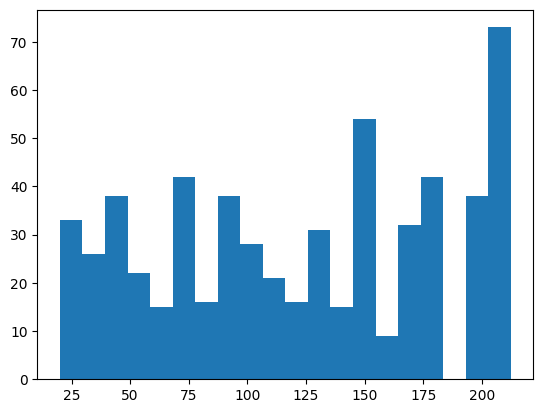

common sections = set()


In [62]:
#check distribution of synapses

from scipy.stats import skew
from scipy.stats import kurtosis


distances = [h.distance(loc) for loc in cell.syn_locs]

print("Summary:")
print(f"  Mean distance: {sum(distances)/len(distances):.1f} µm")
print(f"  Min distance:  {min(distances):.1f} µm")
print(f"  Max distance:  {max(distances):.1f} µm")
print(f"skew: {skew(distances)} (uniform = 0)")
print(f"kurtosis: {kurtosis(distances)} (uniform is 1.8, or -1.2 if excess kurtosis)")

plt.hist(distances,bins=20)
plt.show()
#make sure sections are not reused in other section lists
common_sections = set(cell.proximal_dend_segs) & set(cell.distal_dend_segs)
print(f"common sections = {common_sections}")

In [74]:

from neuron import h  # gui not needed in headless scripts

# Set recording vectors
tvec = h.Vector().record(h._ref_t)
vvec = h.Vector().record(cell.soma[0](0.5)._ref_v)  # somatic Vm

# Simulation control
h.finitialize(cell.Vinit)
h.dt = 0.025
h.tstop = 500.0  # ms
h.run()


0.0

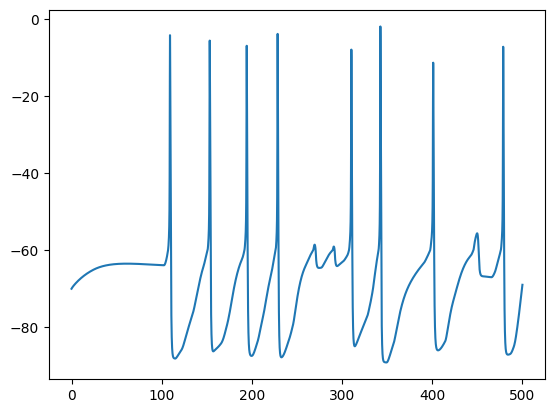

In [75]:
T,V = np.array(tvec),np.array(vvec)
plt.plot(T,V)
# plt.vlines(100,ymin=min(V),ymax=max(V),color = 'r')

Detected spikes at: [109.2   153.25  194.275 228.55  310.3   342.475 401.05  478.675]


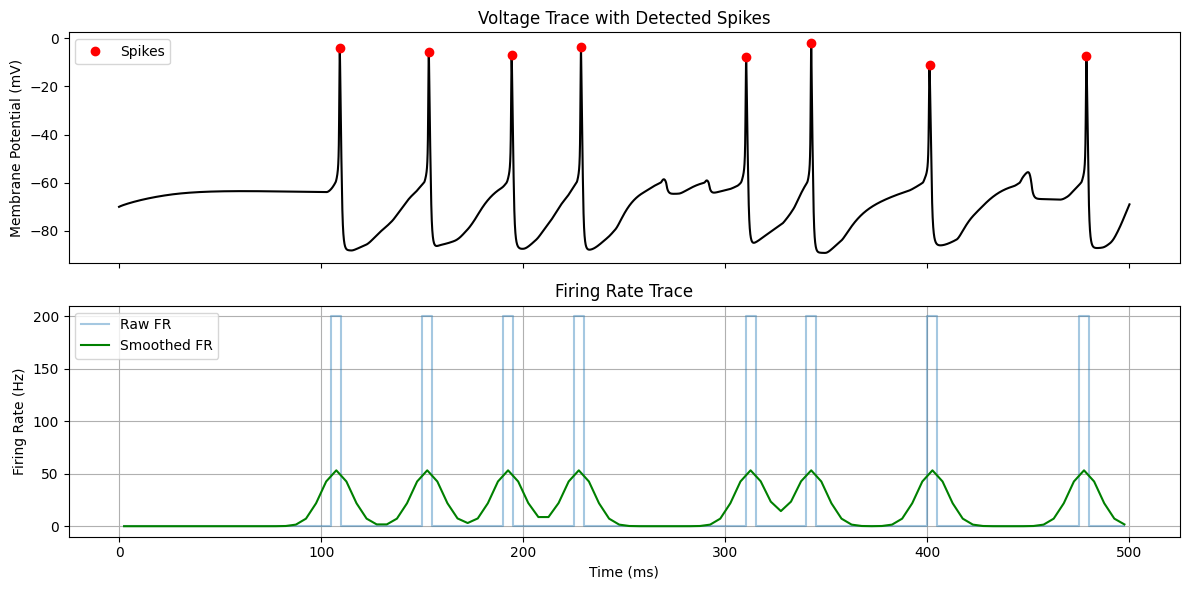

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d



# --- Step 1: Find spikes using find_peaks ---
# You can adjust height and distance to suit your actual trace
peaks, _ = find_peaks(V, height=-20, distance=2)  # height > 0 mV as a basic threshold
spike_times = T[peaks]

print("Detected spikes at:", spike_times)

# --- Step 2: Bin spike times to get firing rate ---
bin_width = 5  # ms
t_min = T[0]
t_max = T[-1]
bins = np.arange(t_min, t_max + bin_width, bin_width)
bin_centers = bins[:-1] + bin_width / 2

# Histogram: spike counts per bin
counts, _ = np.histogram(spike_times, bins=bins)

# Convert to Hz (spikes/sec in each bin)
firing_rate = counts / (bin_width / 1000)  # Hz

# Optional: Smooth with Gaussian filter
smoothed_fr = gaussian_filter1d(firing_rate, sigma=1.5)

# --- Step 3: Plot voltage and firing rate ---
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Voltage trace
axs[0].plot(T, V, color='black')
axs[0].plot(spike_times, V[peaks], 'ro', label='Spikes')
axs[0].set_ylabel('Membrane Potential (mV)')
axs[0].set_title('Voltage Trace with Detected Spikes')
axs[0].legend()

# Firing rate trace
axs[1].plot(bin_centers, firing_rate, drawstyle='steps-mid', alpha=0.4, label='Raw FR')
axs[1].plot(bin_centers, smoothed_fr, color='green', label='Smoothed FR')
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Firing Rate (Hz)')
axs[1].set_title('Firing Rate Trace')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [17]:
import random

In [119]:
def run_cell(cell):
            # Set recording vectors
    tvec = h.Vector().record(h._ref_t)
    vvec = h.Vector().record(cell.soma[0](0.5)._ref_v)  # somatic Vm

    # Simulation control
    h.finitialize(cell.Vinit)
    h.dt = 0.025
    h.tstop = 500.0  # ms
    h.run()
    return tvec,vvec

In [120]:
No_Cells = 10
ts,vs = [],[]
cell = AllenCell(0,soma_diam_multiplier=6)

for i in range(No_Cells):
    
    cell.syn_locs = []
    cell.vecs = []
    cell.stims = []
    cell.synapses = []
    cell.netcons = []
    
    N_stim = 10
    all_spike_times = []
    bin_size = 5


    for i in range(N_stim):

        spikes=inhomogeneous_poisson_through_num_points(PFR_firing_rate_shortened,int(bin_size))
        time = np.arange(len(spikes))
        timestamps = time[spikes==1]
        all_spike_times.append(timestamps)


    df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_spike_times) for t in times])
    grouped_stim = df.groupby('node_ids')['timestamps'].apply(list).reset_index()
    
    N_background = 20
    all_bg_spikes = []
    for i in range(N_background):
        background_spikes = spike_train_generation.homogeneous_poisson_timestamps(rate_hz=2, duration_ms=500)
        all_bg_spikes.append(background_spikes)

    df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_bg_spikes) for t in times])
    grouped = df.groupby('node_ids')['timestamps'].apply(list).reset_index()
    
    
    cell.add_random_synapses_from_df(grouped, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends,cell.distal_dends])
    cell.add_random_synapses_from_df(grouped_stim, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends])
    t,v = run_cell(cell)
    ts.append(t)
    vs.append(v)





warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [121]:
T = np.concatenate(np.array(ts),axis=0)
V = np.concatenate(np.array(vs),axis=0)

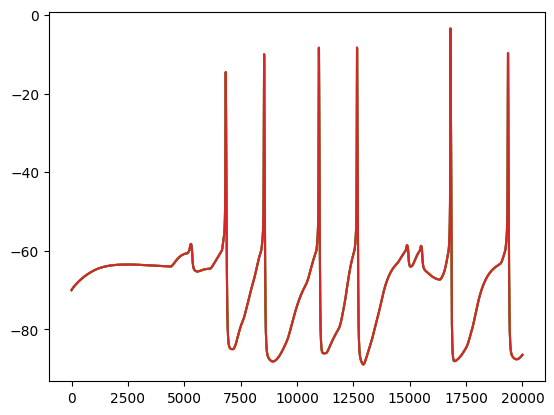

In [127]:
plt.plot(vs[0])
plt.plot(vs[1])
plt.plot(vs[2])
plt.plot(vs[3])
plt.show()